In [17]:
from trustee import ClassificationTrustee
from dbgsom.dbgsom_ import DBGSOM
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from trustee.report.trust import TrustReport
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer


In [47]:
data = pd.read_csv(
    "F:\Dokumente\git\data\CIC-Darknet2020\Darknet.CSV",
    index_col="Flow ID",
    parse_dates=["Timestamp"],
)


# Clean up data
data.replace(
    {
        -np.inf: -1000,
        np.inf: 1000,
        "AUDIO-STREAMING": "Audio-Streaming",
        "File-transfer": "File-Transfer",
        "Video-streaming": "Video-Streaming",
    },
    inplace=True,
)
# convert timestamp to integer
data.Timestamp = data.Timestamp.astype("int64")
X = data.drop(columns=["Label", "Label.1", "Timestamp"])
y_1 = data["Label"]
y_2 = data["Label.1"]

X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = train_test_split(
    X, y_1, y_2, random_state=23, stratify=y_2
)


In [55]:
scaler = PowerTransformer()
imputer = KNNImputer(add_indicator=True)
# One hot encode categorical columns
ohe = OneHotEncoder(max_categories=10, handle_unknown="infrequent_if_exist")
col_transformer = ColumnTransformer(
    transformers=[
        ("ohe", ohe, ["Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
som = DBGSOM(
    max_iter=300,
    random_state=32,
    convergence_iter=5,
    spreading_factor=1.5,
    verbose=True,
    max_neurons=300,
    growth_criterion="entropy",
)

pipe = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("scaler", scaler),
        ("imputer", imputer),
        ("som", som),
    ]
)

pipe_small = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("scaler", scaler),
        ("imputer", imputer),
    ]
)

# y_train = y_1_train
y_train = y_2_train


In [56]:
pipe.fit(X_train, y_train)
pipe_small.fit(X_train, y_train)


 53%|█████▎    | 159/300 [00:53<00:47,  3.00 epochs/s]


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=10),
                                                  ['Src IP', 'Src Port',
                                                   'Dst IP', 'Dst Port',
                                                   'Protocol'])],
                                   verbose_feature_names_out=False)),
                ('scaler', PowerTransformer()),
                ('imputer', KNNImputer(add_indicator=True))])

In [68]:
y_pred = pipe.predict(X_test)


trustee = ClassificationTrustee(expert=som)
trustee.fit(pipe_small.transform(X_train), y_train, num_samples=800)
dt, pruned_dt, agreement, reward = trustee.explain()
dt_y_pred = dt.predict(pipe_small.transform(X_test))
print("Model explanation global fidelity report:")
print(classification_report(y_pred, dt_y_pred))
print("Model explanation score report:")
print(classification_report(y_2_test, dt_y_pred))


Model explanation global fidelity report:


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

             -1       0.00      0.00      0.00         2
Audio-Streaming       0.80      0.85      0.82      4941
       Browsing       0.95      0.94      0.94     10029
           Chat       0.91      0.95      0.93      4015
          Email       0.28      0.20      0.23       380
  File-Transfer       0.66      0.62      0.64      2082
            P2P       0.92      0.94      0.93     12244
           VOIP       0.34      0.14      0.20       242
Video-Streaming       0.76      0.54      0.63      1448

       accuracy                           0.88     35383
      macro avg       0.62      0.58      0.59     35383
   weighted avg       0.88      0.88      0.88     35383

Model explanation score report:
                 precision    recall  f1-score   support

Audio-Streaming       0.66      0.77      0.71      4516
       Browsing       0.78      0.94      0.85      8202
           Chat       0.54      0.78      0.64      

In [51]:
trust_report = TrustReport(
    som,
    X=pipe_small.transform(X_test),
    y=y_test,
    max_iter=5,
    num_pruning_iter=5,
    train_size=0.7,
    trustee_num_iter=5,
    trustee_num_stability_iter=5,
    trustee_sample_size=0.3,
    analyze_branches=True,
    analyze_stability=True,
    top_k=10,
    verbose=False,
    class_names=y_train.unique(),
    feature_names=pipe_small.get_feature_names_out(),
    is_classify=True,
)

print(trust_report)


Running Trust Report...


 94%|█████████▍| 94/100 [00:11<00:00,  7.97 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.10 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.23 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.36 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.31 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.42 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.17 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.21 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.21 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.22 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.19 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.27 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.24 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.24 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.24 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.25 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.25 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.28 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.17 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.21 epochs/s]


 94%|█████████▍| 94/100 [00:11<00:00,  8.00 epochs/s]


 81%|████████  | 81/100 [00:09<00:02,  8.91 epochs/s]


 78%|███████▊  | 78/100 [00:08<00:02,  8.67 epochs/s]


Progress |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete


100%|██████████| 100/100 [00:12<00:00,  8.24 epochs/s]


Progress |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete


 74%|███████▍  | 74/100 [00:08<00:02,  8.92 epochs/s]


Progress |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete


 76%|███████▌  | 76/100 [00:08<00:02,  9.41 epochs/s]


Progress |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete
Progress |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                    Classification Trust Report                                                                                                                    |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

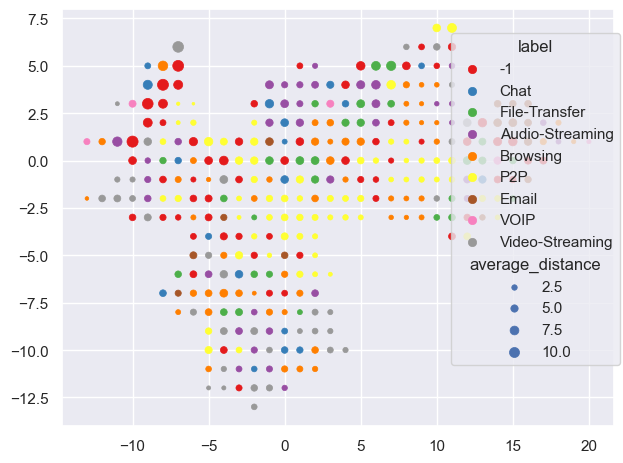

In [60]:
som.plot(color="label", palette="Set1", pointsize="average_distance")
